<a href="https://colab.research.google.com/github/haldonmez/mnist-digit-recognizer/blob/main/Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn

import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

print(f"Pytorch version: {torch.__version__}\ntorchvision version:{torchvision.__version__}")

Pytorch version: 2.2.1+cu121
torchvision version:0.17.1+cu121


In [3]:
data = "/content/data"
train_data = datasets.MNIST(
    root=data,
    train= True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = datasets.MNIST(
    root=data,
    train=False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 111992671.09it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28382308.77it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23740577.58it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4383462.67it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 1875 iterations with the batch size of 32.
For testing data there is 313 iterations with the batch size of 32.


Lets try to get a optimum variance value by self picking 0-1 as background values and the rest as foreground values.

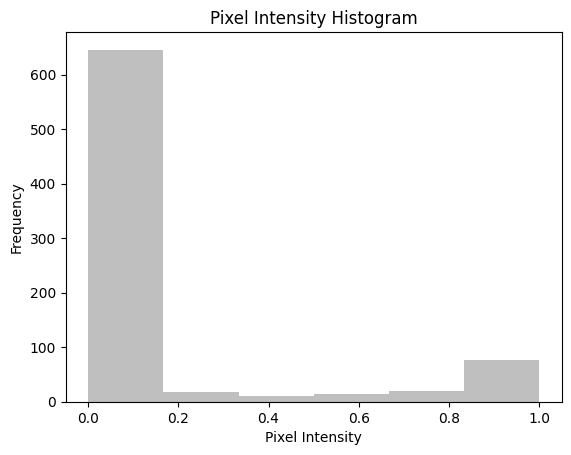

646.0
17.0
10.0
15.0
20.0
76.0

The threshold we got from the self picked values is 0.25970596455305495

The weight values are: 0.8456632653061225, 0.15433673469387754

The mean intensity values are: 0.004273504400864625, 0.7231404874935623


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math
# Get an example image and a label.
image, label = train_data[0]

# Flattened the image so we can get the values in a single 1d matrix.
flatten_image = nn.Flatten()
image_flattened = flatten_image(image)

# Creating a histogram to check the mean of the background and foreground.
hist, bin_edges, number_of_x_values= plt.hist(image_flattened, bins=6, color='gray', alpha=0.5)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# We can calculate back to 784 and check if the histogram is correct.
total_weight = np.sum(hist)

# The sum of the values varying to their intensity levels.
for i in range(len(bin_edges)-1):
  print(hist[i])

# Weight values calculated for self-picked value of 0-1 to background and the rest for foreground.
Wb = (hist[0]+hist[1])/total_weight
Wf = (hist[2]+hist[3]+hist[4]+hist[5])/total_weight

# Calculating the mean variance of the background and foreground values which we self picked before hand.
Ub = ((hist[0]*bin_edges[0])+(hist[1]*bin_edges[1]))/(hist[0]+hist[1])
Uf = ((hist[2]*bin_edges[2])+(hist[3]*bin_edges[3])+(hist[4]*bin_edges[4])+(hist[5]*bin_edges[5]))/(hist[2]+hist[3]+hist[4]+hist[5])

# Getting the variance value based on Otsu's Method to get a number if our self picked number's variance is the best.
variance = math.sqrt((Wb*Wf)*((Ub-Uf)*(Ub-Uf)))

print(f"\nThe threshold we got from the self picked values is {variance}")
print(f"\nThe weight values are: {Wb}, {Wf}")
print(f"\nThe mean intensity values are: {Ub}, {Uf}")

This snippet calculates a variance number based on our self picked values which is "0.25970596455305495". We need to functionize this to get the best - highest - variance value to implement in our Otsu's threshold method.

In [6]:
import numpy as np
def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1
    return thresholded_im

In [7]:
im_otsu = threshold_image(image, variance)

Text(0.5, 1.0, "After Otsu's model")

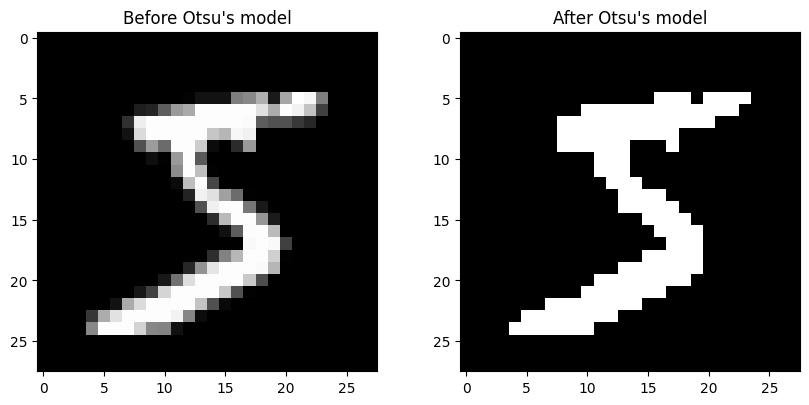

In [8]:
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(image.squeeze(),cmap='gray')
plt.title("Before Otsu's model")
plt.subplot(322); plt.imshow(im_otsu.squeeze(),cmap='gray')
plt.title("After Otsu's model")

Lets functionize Otsu's model to get the optimal variance based of our given image.

In [9]:
import matplotlib.pyplot as plt
import numpy as numpy
import math

def findGreatestThreshold(img):
  # First we flatten the image to get the 1D matrix.
  flatten_image = nn.Flatten()
  image_flattened = flatten_image(image)

  # Then we get the axial values of the image.
  counts, binominal_values= np.histogram(image_flattened, bins=6)
  # Counts = The number of times that intensity was displayed
  # Binominal_values = The levels of intensity in our case its [0., 0.16666667, 0.33333334, 0.5, 0.66666669, 0.83333331, 1.]

  # We get the total weight for our calculations.
  total_weight = np.sum(counts)

  # We assign an empty list to store the threshold values.
  List = []

  # We iterate for all the threshold values to get the highest.
  for i in range(len(binominal_values)-1):
    current_weight = 0
    current_intensity = 0
    foreground_intensity = 0
    foreground_weight = 0

    # We iterate for the background calculations.
    for j in range(i+1):
      current_weight += counts[j]
      current_intensity += counts[j]*binominal_values[j]

    # We iterate for the foreground calculations.
    for k in range(len(binominal_values)-2, i,-1):
      foreground_intensity += counts[k]*binominal_values[k]

    foreground_weight = total_weight - current_weight

    # We calculate the mean intensities for every threshold.
    Ub = current_intensity / current_weight
    Uf = foreground_intensity / foreground_weight if foreground_weight != 0 else 0.0

    # We calculate the weights for every threshold.
    Wb = current_weight / total_weight
    Wf = 1 - Wb

    # We calculate the variance for every threshold.
    variance = math.sqrt((Wb*Wf)*((Ub-Uf)*(Ub-Uf)))

    # We append the threshold values to the empty list to apply max() and get the optimal threshold value.
    List.append(variance)

  return List

In [10]:
best_variance = max(findGreatestThreshold(image))
for i in range(len(findGreatestThreshold(image))):
  print(f"The threshold for the {i+1}. value selected is: {findGreatestThreshold(image)[i]}")

print(f"\nThis gives us the optimal value of >> {max(findGreatestThreshold(image))}")

The threshold for the 1. value selected is: 0.24929219686862017
The threshold for the 2. value selected is: 0.25970596455305495
The threshold for the 3. value selected is: 0.2611499991255095
The threshold for the 4. value selected is: 0.25527602266857763
The threshold for the 5. value selected is: 0.2352786329811753
The threshold for the 6. value selected is: 0.0

This gives us the optimal value of >> 0.2611499991255095


In [11]:
import numpy as np
def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1
    return thresholded_im

In [12]:
image_otsu = threshold_image(image, best_variance)

This is normaltorch.float32
This is otsutorch.float32


Text(0.5, 1.0, '2')

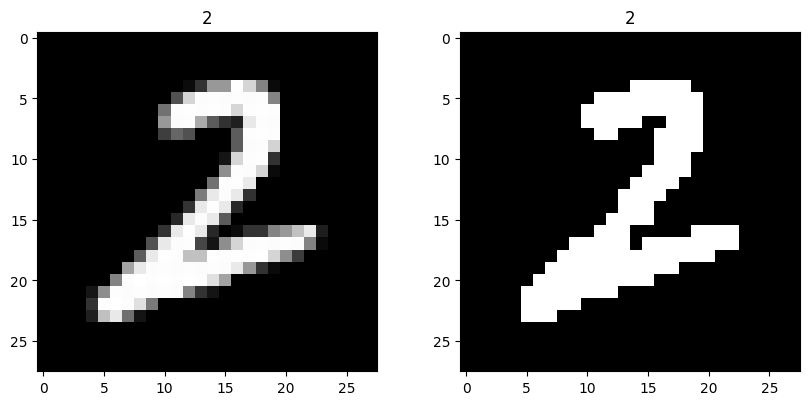

In [41]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
import random

dataset_path = '/content/data/MNIST/MNIST_Traning_Otsu/dataset.pt'

if not os.path.exists(dataset_path):
  train_data_otsu2 = [(torch.tensor(threshold_image(image[0], 0.2611499991255095)).unsqueeze(0).float(), label) for image, label in train_data]
  torch.save(train_data_otsu2, dataset_path)
else:
    # If the dataset already exists, load it
    train_data_otsu2 = torch.load(dataset_path)

random_number = random.randint(0,len(train_data_otsu2))
image, label = train_data[random_number]
image2, label2 = train_data_otsu2[random_number]
image2.shape, image.shape
print(f"This is normal{train_data[0][0].dtype}")
print(f"This is otsu{train_data_otsu2[0][0].dtype}")
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(image.squeeze(),cmap='gray')
plt.title(label)
plt.subplot(322); plt.imshow(image2.squeeze(),cmap='gray')
plt.title(label2)

In [54]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 1875 iterations with the batch size of 32.
For testing data there is 313 iterations with the batch size of 32.


Text(0.5, 1.0, "After Otsu's model 2.0(optimal)")

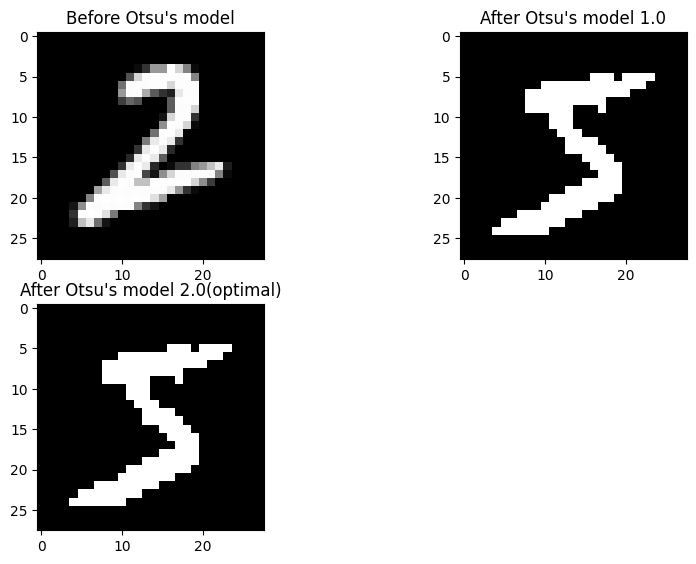

In [55]:
plt.figure(figsize=(10,10))
plt.subplot(321); plt.imshow(image.squeeze(),cmap='gray')
plt.title("Before Otsu's model")
plt.subplot(322); plt.imshow(im_otsu.squeeze(),cmap='gray')
plt.title("After Otsu's model 1.0")
plt.subplot(323); plt.imshow(image_otsu.squeeze(),cmap='gray')
plt.title("After Otsu's model 2.0(optimal)")

In [56]:
# Setup GPU as a available device.

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"This model currently runs on {device}")

# T4 GPU must be activated in Google Colab to add GPU.

This model currently runs on cpu


In [57]:
from torch import nn
class DigitRecognizerMNISTV2(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [58]:
torch.manual_seed(42)

model_2 = DigitRecognizerMNISTV2(input_shape=784,
                                 hidden_units=10,
                                 output_shape=len(train_data.classes)).to(device)

next(model_2.parameters()).device

device(type='cpu')

In [59]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [61]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [62]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.5f}, Test accuracy is:{test_acc:.2f}%")

In [63]:
torch.manual_seed(42)
from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_part(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func
    )
    test_part(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func
    )

train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss is:0.45602, Train accuracy is:86.75%
Test loss is:0.26454, Test accuracy is:92.02%
Epoch: 1
---------
Train loss is:0.27140, Train accuracy is:92.00%
Test loss is:0.24936, Test accuracy is:92.90%
Epoch: 2
---------
Train loss is:0.24100, Train accuracy is:92.94%
Test loss is:0.23292, Test accuracy is:93.17%
Epoch: 3
---------
Train loss is:0.22615, Train accuracy is:93.28%
Test loss is:0.22074, Test accuracy is:93.56%
Epoch: 4
---------
Train loss is:0.21686, Train accuracy is:93.59%
Test loss is:0.20750, Test accuracy is:93.97%
Train time on cpu: 75.632 seconds


As we can compare applying Otsu's Method to only training dataset part made it run 3 times faster. But there were no performance improvements.

Epoch: 0
---------
Train loss is:0.58748, Train accuracy is:82.00%
Test loss is:0.29271, Test accuracy is:91.52%
Epoch: 1
---------
Train loss is:0.29283, Train accuracy is:91.33%
Test loss is:0.27770, Test accuracy is:92.02%
Epoch: 2
---------
Train loss is:0.26462, Train accuracy is:92.15%
Test loss is:0.25494, Test accuracy is:92.46%
Epoch: 3
---------
Train loss is:0.24732, Train accuracy is:92.70%
Test loss is:0.23980, Test accuracy is:93.12%
Epoch: 4
---------
Train loss is:0.23911, Train accuracy is:92.94%
Test loss is:0.22759, Test accuracy is:93.23%
Train time on cpu: 21.318 seconds